In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web

from linearmodels.asset_pricing import LinearFactorModel

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('whitegrid')

In [7]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2010', end='2017-12')[0]

In [9]:
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  96 non-null     float64
 1   SMB     96 non-null     float64
 2   HML     96 non-null     float64
 3   RMW     96 non-null     float64
 4   CMA     96 non-null     float64
 5   RF      96 non-null     float64
dtypes: float64(6)
memory usage: 5.2 KB


In [10]:
ff_factor_data.describe()

,Mkt-RF,SMB,HML,RMW,CMA,RF
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.158438,0.060000,-0.049271,0.129896,0.047708,0.012604
std,3.580012,2.300292,2.202912,1.581930,1.413033,0.022583
min,-7.890000,-4.580000,-4.700000,-3.880000,-3.240000,0.000000
25%,-0.917500,-1.670000,-1.665000,-1.075000,-0.952500,0.000000
50%,1.235000,0.200000,-0.275000,0.210000,0.010000,0.000000
75%,3.197500,1.582500,1.205000,1.235000,0.930000,0.010000
max,11.350000,7.040000,8.190000,3.480000,3.690000,0.090000


In [14]:
ff_portfolio = '17_Industry_portfolios'
ff_portfolio_data = web.DataReader(ff_portfolio, 'famafrench', start='2010', end='2017-12')[0]
ff_portfolio_data = ff_portfolio_data.sub(ff_factor_data.RF, axis=0)
ff_portfolio_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 96 entries, 2010-01 to 2017-12
Freq: M
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Food    96 non-null     float64
 1   Mines   96 non-null     float64
 2   Oil     96 non-null     float64
 3   Clths   96 non-null     float64
 4   Durbl   96 non-null     float64
 5   Chems   96 non-null     float64
 6   Cnsum   96 non-null     float64
 7   Cnstr   96 non-null     float64
 8   Steel   96 non-null     float64
 9   FabPr   96 non-null     float64
 10  Machn   96 non-null     float64
 11  Cars    96 non-null     float64
 12  Trans   96 non-null     float64
 13  Utils   96 non-null     float64
 14  Rtail   96 non-null     float64
 15  Finan   96 non-null     float64
 16  Other   96 non-null     float64
dtypes: float64(17)
memory usage: 13.5 KB


In [15]:
ff_portfolio_data.describe()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,1.046771,0.202917,0.597187,1.395833,1.151458,1.305000,1.186979,1.735521,0.559167,1.350521,1.217708,1.279479,1.463750,0.896458,1.233958,1.248646,1.290938
std,2.800555,7.904401,5.480938,5.024408,5.163951,5.594161,3.142989,5.243314,7.389679,4.694408,4.798098,5.719351,4.143005,3.233107,3.512518,4.839150,3.697608
min,-5.170000,-24.380000,-11.680000,-10.000000,-13.160000,-17.390000,-7.150000,-14.160000,-20.490000,-11.960000,-9.070000,-11.650000,-8.560000,-6.990000,-9.180000,-11.140000,-7.890000
25%,-0.785000,-5.840000,-3.117500,-1.865000,-2.100000,-1.445000,-0.855000,-2.410000,-4.395000,-1.447500,-2.062500,-1.245000,-0.810000,-0.737500,-0.952500,-1.462500,-1.090000
50%,0.920000,-0.435000,0.985000,1.160000,1.225000,1.435000,1.465000,2.175000,0.660000,1.485000,1.525000,0.635000,1.480000,1.240000,0.865000,1.910000,1.660000
75%,3.187500,5.727500,4.152500,3.857500,4.160000,4.442500,3.302500,5.557500,4.212500,3.837500,4.580000,4.802500,4.242500,2.965000,3.370000,4.100000,3.485000
max,6.670000,21.940000,15.940000,17.190000,16.610000,18.370000,8.260000,15.510000,21.350000,17.660000,14.750000,20.860000,12.980000,7.840000,12.440000,13.410000,10.770000


In [16]:
with pd.HDFStore('../data/assets.h5') as store:
    prices = store['/quandl/wiki/prices'].adj_close.unstack().loc['2010':'2017']
    equities = store['/us_equities/stocks'].drop_duplicates()

In [28]:
sectors = equities.filter(prices.columns, axis=0).sector.to_dict()
prices = prices.filter(sectors.keys()).dropna(how='all', axis=1)

In [36]:
returns = prices.resample('M').last().pct_change().mul(100).to_period('M')
returns = returns.dropna(how='all').dropna(axis=1)

In [38]:
ff_factor_data = ff_factor_data.loc[returns.index]
ff_portfolio_data = ff_portfolio_data.loc[returns.index]

In [22]:
prices.columns

Index(['A', 'AA', 'AAL', 'AAMC', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPL', 'AAT',
       ...
       'ZIOP', 'ZIXI', 'ZLC', 'ZLTQ', 'ZMH', 'ZNGA', 'ZOES', 'ZQK', 'ZTS',
       'ZUMZ'],
      dtype='object', name='ticker', length=3199)

In [39]:
returns

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YRCW,YUM,ZAGG,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2010-02,12.236889,38.041431,7.757848,2.185527,3.422053,6.537959,22.934279,5.440199,3.163980,1.713062,...,-50.549451,-1.432330,29.702970,1.793327,9.463602,-0.220951,-2.212411,6.389776,2.659574,12.647290
2010-03,9.313414,0.272851,13.068473,7.509506,2.887175,14.847034,17.679681,7.089405,3.138374,-4.215479,...,17.777778,13.671412,8.015267,3.261816,3.605180,18.040492,17.799353,52.552553,19.689119,42.887029
2010-04,5.437627,-3.809524,3.646409,6.763926,7.585878,11.102128,4.184731,-4.771975,6.673582,23.255814,...,3.773585,11.228094,7.416961,2.888512,-1.858108,-2.664625,31.547619,16.535433,6.926407,-9.419229
2010-05,-10.755654,24.893918,-14.658849,2.194617,14.767184,-1.612471,-5.427899,-13.063628,1.658232,1.257862,...,-35.418182,-3.465347,-22.694825,-8.175997,-5.335628,-13.214885,-16.606132,-14.695946,-4.858300,-7.758621
2010-06,-12.144623,-2.491506,-14.363696,-4.808984,-2.938203,-2.082685,-9.125694,-4.797868,1.502558,-13.874292,...,-57.770270,-4.664225,22.127660,-3.361346,-7.745455,-16.654572,-9.937370,-37.029703,-3.829787,-5.899533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,8.245526,-11.117858,-4.343129,-3.550296,-12.597090,10.625073,12.457912,-1.357917,-14.073315,-3.820961,...,0.752445,1.775305,49.112426,-5.811078,1.346834,6.905658,-3.406683,15.551537,-0.375235,-1.968504
2017-09,-0.803461,6.146625,-1.383225,5.751534,1.392784,-6.024390,-1.497006,-3.396798,3.115265,9.080827,...,3.061987,-4.178599,25.000000,2.685355,5.325444,20.547945,8.062300,-3.912363,-7.909605,45.381526
2017-10,6.181355,-1.410823,-15.654366,1.522843,-17.600806,9.680768,-6.762918,8.398656,-7.009063,-0.104275,...,-2.391304,1.141149,-0.634921,3.868819,6.824461,-14.181818,-1.526070,-24.104235,-0.817996,-2.486188


In [42]:
excess_returns = returns.sub(ff_factor_data.RF, axis=0)

In [43]:
excess_returns = excess_returns.clip(lower=np.percentile(excess_returns, 1),
                                    upper=np.percentile(excess_returns, 99))

In [44]:
excess_returns

ticker,A,AAL,AAN,AAON,AAP,AAPL,AAWW,ABAX,ABC,ABCB,...,YRCW,YUM,ZAGG,ZBH,ZBRA,ZEUS,ZION,ZIOP,ZIXI,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2010-02,12.236889,33.993800,7.757848,2.185527,3.422053,6.537959,22.934279,5.440199,3.163980,1.713062,...,-26.323956,-1.432330,29.702970,1.793327,9.463602,-0.220951,-2.212411,6.389776,2.659574,12.647290
2010-03,9.303414,0.262851,13.058473,7.499506,2.877175,14.837034,17.669681,7.079405,3.128374,-4.225479,...,17.767778,13.661412,8.005267,3.251816,3.595180,18.030492,17.789353,33.993800,19.679119,33.993800
2010-04,5.427627,-3.819524,3.636409,6.753926,7.575878,11.092128,4.174731,-4.781975,6.663582,23.245814,...,3.763585,11.218094,7.406961,2.878512,-1.868108,-2.674625,31.537619,16.525433,6.916407,-9.429229
2010-05,-10.765654,24.883918,-14.668849,2.184617,14.757184,-1.622471,-5.437899,-13.073628,1.648232,1.247862,...,-26.323956,-3.475347,-22.704825,-8.185997,-5.345628,-13.224885,-16.616132,-14.705946,-4.868300,-7.768621
2010-06,-12.154623,-2.501506,-14.373696,-4.818984,-2.948203,-2.092685,-9.135694,-4.807868,1.492558,-13.884292,...,-26.323956,-4.674225,22.117660,-3.371346,-7.755455,-16.664572,-9.947370,-26.323956,-3.839787,-5.909533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08,8.155526,-11.207858,-4.433129,-3.640296,-12.687090,10.535073,12.367912,-1.447917,-14.163315,-3.910961,...,0.662445,1.685305,33.993800,-5.901078,1.256834,6.815658,-3.496683,15.461537,-0.465235,-2.058504
2017-09,-0.893461,6.056625,-1.473225,5.661534,1.302784,-6.114390,-1.587006,-3.486798,3.025265,8.990827,...,2.971987,-4.268599,24.910000,2.595355,5.235444,20.457945,7.972300,-4.002363,-7.999605,33.993800
2017-10,6.091355,-1.500823,-15.744366,1.432843,-17.690806,9.590768,-6.852918,8.308656,-7.099063,-0.194275,...,-2.481304,1.051149,-0.724921,3.778819,6.734461,-14.271818,-1.616070,-24.194235,-0.907996,-2.576188


In [48]:
ff_factor_data = ff_factor_data.drop('RF', axis=1)

In [49]:
betas = []
for industry in ff_portfolio_data:
    step1 = OLS(endog=ff_portfolio_data.loc[ff_factor_data.index, industry], 
                exog=add_constant(ff_factor_data)).fit()
    betas.append(step1.params.drop('const'))

In [50]:
betas = pd.DataFrame(betas,
                    columns=ff_factor_data.columns,
                    index=ff_portfolio_data.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, Food  to Other
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  17 non-null     float64
 1   SMB     17 non-null     float64
 2   HML     17 non-null     float64
 3   RMW     17 non-null     float64
 4   CMA     17 non-null     float64
dtypes: float64(5)
memory usage: 1.3+ KB


In [70]:
betas

,Mkt-RF,SMB,HML,RMW,CMA
Food,0.685224,-0.309243,-0.356449,0.307267,0.488021
Mines,1.308261,0.183406,0.223125,0.221233,0.535162
Oil,1.034249,0.170154,0.647615,0.002943,0.316127
Clths,0.966317,0.360844,-0.143478,0.620782,-0.031285
Durbl,1.178329,0.530518,0.067285,0.545466,-0.115544
Chems,1.351916,0.179614,0.189708,0.167718,-0.240664
Cnsum,0.760266,-0.341041,-0.554683,-0.055728,0.582263
Cnstr,1.114650,0.428757,0.090067,-0.017382,0.167269
Steel,1.468801,0.421623,0.419775,0.196493,0.437610
FabPr,1.068019,0.464198,-0.037967,0.163900,0.198155


In [71]:
lambdas = []
for period in ff_portfolio_data.index:
    step2 = OLS(endog=ff_portfolio_data.loc[period, betas.index], 
                exog=betas).fit()
    lambdas.append(step2.params)

In [72]:
lambdas = pd.DataFrame(lambdas, 
                       index=ff_portfolio_data.index,
                       columns=betas.columns.tolist())

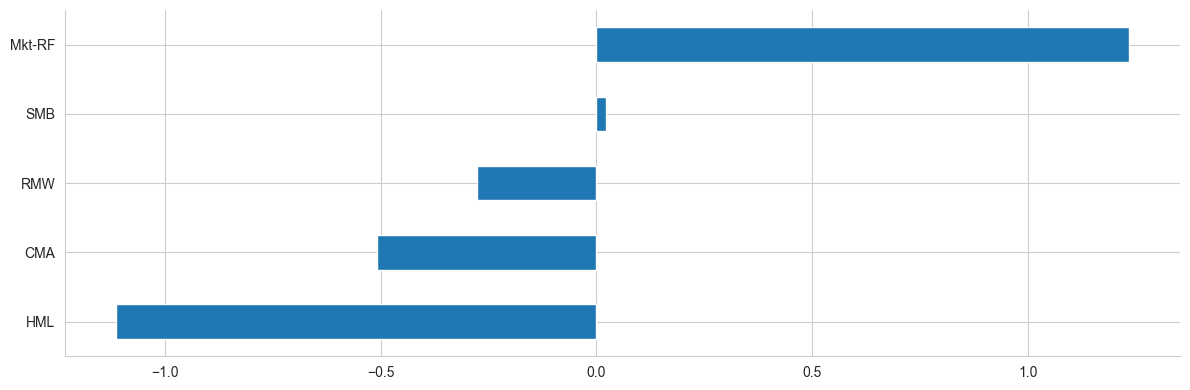

In [75]:
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

In [76]:
t = lambdas.mean().div(lambdas.std())
t

Mkt-RF    0.344270
SMB       0.005458
HML      -0.269333
RMW      -0.091369
CMA      -0.144953
dtype: float64

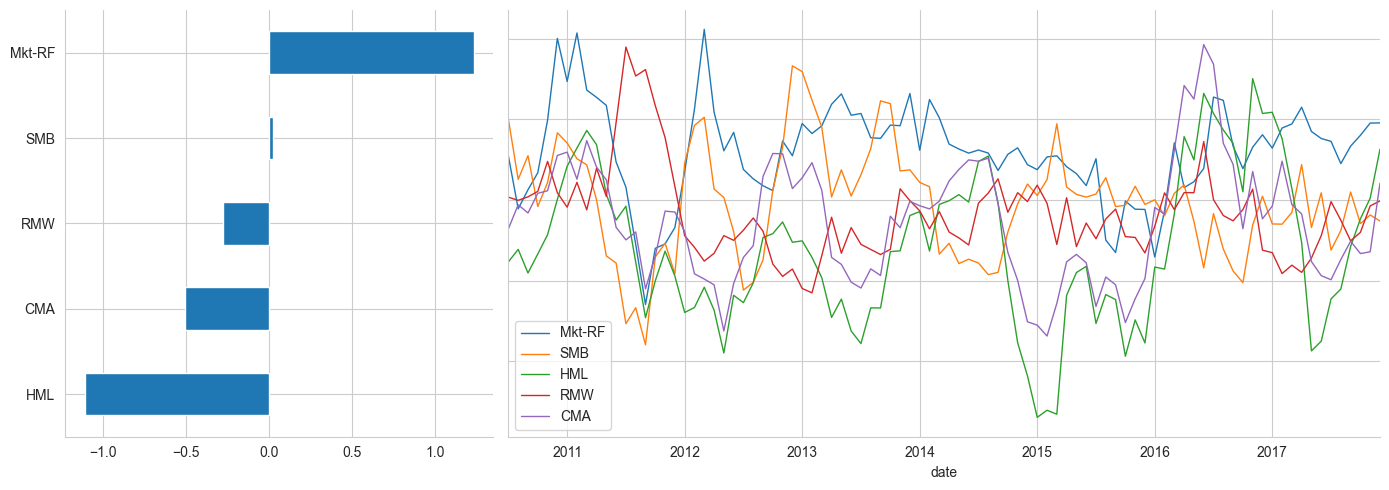

In [85]:
window = 6  # months
ax1 = plt.subplot2grid((1, 3), (0, 0))
ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=2)
lambdas.mean().sort_values().plot.barh(ax=ax1)
lambdas.rolling(window).mean().dropna().plot(lw=1,
                                             figsize=(14, 5),
                                             sharey=True,
                                             ax=ax2)
sns.despine()
plt.tight_layout()